In [ ]:
# This file takes the segmented swimbladder masks from the top and side view, and reconstructs the 3D volume.
# Written by Kevin Li, May 2025

# Importing relevant packages
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import cv2
from matplotlib.patches import Ellipse
import mpl_toolkits.mplot3d.art3d as art3d
from tqdm import tqdm
import csv
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
import os

In [ ]:
# This function obtains the 2D ellipse from the mask via OpenCV
def getEllipse(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)   
    contour_points = contours[0] 
    if len(contour_points) < 5:
        contour_points = contours[1]
    ellipse = cv2.fitEllipse(contour_points)
    result = mask.copy()
    cv2.ellipse(result, ellipse, (1, 0, 0), 2)
    return ellipse, result, contours

# Creates the matrix for the 2D ellipse
def ellipse_matrix(ellipse_input):
    ellipse_a = ellipse_input['a']
    ellipse_b = ellipse_input['b']
    ellipse_theta = ellipse_input['theta']

    D_ellipse = np.diag([1 / ellipse_a**2, 1 / ellipse_b**2])
    ellipse_R = np.array([[np.cos(ellipse_theta), -np.sin(ellipse_theta)],
                            [np.sin(ellipse_theta), np.cos(ellipse_theta)]])
    
    ellipse_Q = ellipse_R.T @ D_ellipse @ ellipse_R
    return ellipse_Q

# This function takes a given 3D ellipse and obtains its 2D projections
def project_ellipsoid_to_plane(a, b, c, R, plane):
    D_inv = np.diag([1 / a**2, 1 / b**2, 1 / c**2])

    Q = R.T @ D_inv @ R 

    if plane == 'xy':
        Q_plane = Q[:2, :2]
    elif plane == 'xz':
        Q_plane = Q[[0, 2], :][:, [0, 2]]
    elif plane == 'yz':
        Q_plane = Q[1:, 1:]

    return Q_plane, Q

# This function reconstructs the 3D ellipsoid through least squares optimization, by matching 2D projections
# of our generated 3D ellipsoid to the 2D ellipsoids generated from our masks via OpenCV
def ellipsoid_from_projections(ellipse_xy, ellipse_xz):

    def objective(params):
        a, b, c, phi, theta, psi = params

        # Construct rotation matrix from Euler angles
        Rz_phi = np.array([[np.cos(phi), -np.sin(phi), 0],
                           [np.sin(phi), np.cos(phi), 0],
                           [0, 0, 1]])
        Ry_theta = np.array([[np.cos(theta), 0, np.sin(theta)],
                             [0, 1, 0],
                             [-np.sin(theta), 0, np.cos(theta)]])
        Rx_psi = np.array([[1, 0, 0],
                           [0, np.cos(psi), -np.sin(psi)],
                           [0, np.sin(psi), np.cos(psi)]])
        R = Rz_phi @ Ry_theta @ Rx_psi

        # Compute projections onto the xy and xz planes
        xy_proj, _ = project_ellipsoid_to_plane(a, b, c, R, 'xy')
        xy_real = ellipse_matrix(ellipse_xy)

        res_xy = [
            xy_real[0][0] - xy_proj[0][0],
            xy_real[0][1] - xy_proj[0][1],
            xy_real[1][0] - xy_proj[1][0],
            xy_real[1][1] - xy_proj[1][1],
        ]
        
        # Residuals for the xz-plane projection
        xz_proj,_ = project_ellipsoid_to_plane(a, b, c, R, 'xz')
        xz_real = ellipse_matrix(ellipse_xz)
        res_xz = [
            xz_real[0][0] - xz_proj[0][0], 
            xz_real[0][1] - xz_proj[0][1],
            xz_real[1][0] - xz_proj[1][0],
            xz_real[1][1] - xz_proj[1][1],
        ]

        return res_xy + res_xz

    # Initial guess for optimization
    initial_guess = [ellipse_xy['b'], ellipse_xy['a'], ellipse_xz['a'], 0, 0, 0]  # Semi-axes: a, b, c; Euler angles: phi, theta, psi

    # Solve using least-squares optimization
    result = least_squares(objective, initial_guess,bounds=([1e-6, 1e-6, 1e-6, -2*np.pi, -2*np.pi, -2*np.pi], [90, 90, 90, 2*np.pi, 2*np.pi, 2*np.pi]))
    a, b, c, phi, theta, psi = result.x

    # Construct final rotation matrix
    Rz_phi = np.array([[np.cos(phi), -np.sin(phi), 0],
                       [np.sin(phi), np.cos(phi), 0],
                       [0, 0, 1]])
    Ry_theta = np.array([[np.cos(theta), 0, np.sin(theta)],
                         [0, 1, 0],
                         [-np.sin(theta), 0, np.cos(theta)]])
    Rx_psi = np.array([[1, 0, 0],
                       [0, np.cos(psi), -np.sin(psi)],
                       [0, np.sin(psi), np.cos(psi)]])
    rotation_matrix = Rz_phi @ Ry_theta @ Rx_psi

    _, Q = project_ellipsoid_to_plane(a, b, c, rotation_matrix, 'xz')

    return a, b, c, rotation_matrix, phi, theta, psi, Q

# Fn to plot our ellipsoid for visualization purposes
def plot_ellipsoid(a, b, c, rotation_matrix, center, max_range, top_m, side_m, mask_number):
    x_path, y_path, z_path = center
    x_offset = x_path[mask_number]
    y_offset = y_path[mask_number]
    z_offset = z_path[mask_number]
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = a * np.outer(np.cos(u), np.sin(v))
    y = b * np.outer(np.sin(u), np.sin(v))
    z = c * np.outer(np.ones_like(u), np.cos(v))

    points = np.array([x.ravel(), y.ravel(), z.ravel()])
    
    rotated_points = rotation_matrix @ points

    x_rotated = rotated_points[0, :].reshape(x.shape) + x_offset
    y_rotated = rotated_points[1, :].reshape(y.shape) + y_offset 
    z_rotated = rotated_points[2, :].reshape(z.shape) + z_offset
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.plot_surface(x_rotated, y_rotated, z_rotated, color='cyan', alpha=1)

    p = Ellipse(xy = [x_offset, y_offset], width = top_m[1][0] , height = top_m[1][1], angle = top_m[2])
    ax.add_patch(p)
    art3d.pathpatch_2d_to_3d(p, z=max_range, zdir="z")

    p = Ellipse(xy = [x_offset, z_offset], width = side_m[1][0], height = side_m[1][1], angle = side_m[2])
    ax.add_patch(p)
    art3d.pathpatch_2d_to_3d(p, z=0, zdir="y")

    ax.plot([x_offset, x_offset], [y_offset, 0], [z_offset, z_offset], color='black', alpha=0.5)
    ax.plot([x_offset, x_offset], [y_offset, y_offset], [z_offset, max_range], color='black', alpha=0.5)

    distance = np.sqrt(np.diff(x_path)**2 + np.diff(y_path)**2 + np.diff(z_path)**2)
    total_distance = np.sum(distance)
    cumulative_distance = np.concatenate(([0], np.cumsum(distance)))

    norm = plt.Normalize(0, total_distance)

    for i in range(mask_number):
        ax.plot([x_path[i], x_path[i+1]], [y_path[i], y_path[i+1]], [z_path[i], z_path[i+1]],
                color=cm.viridis(norm(cumulative_distance[i])), linewidth=2)
        
    # sm = cm.ScalarMappable(cmap=cm.viridis, norm=norm)
    # sm.set_array([])  # Dummy array for colorbar
    # cbar = plt.colorbar(sm, ax=ax, shrink=0.4, aspect=20)
    # cbar.set_label("Travel Distance", fontsize = 17)

    # cbar.set_ticks([])
    # cbar.set_ticklabels([])

    ax.set_xlim(0, 800)
    ax.set_ylim(800,0)
    ax.set_zlim(800,0)

    x_ticks = np.linspace(0, 800, 5)  
    y_ticks = np.linspace(800, 0, 5) 
    z_ticks = np.linspace(800, 0, 5)  

    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_zticks(z_ticks)

    ax.set_xticklabels([0, 2, 4, 6, 8], fontsize = 17)
    ax.set_yticklabels([0, 2, 4, 6, 8], fontsize = 17)
    ax.set_zticklabels([0, 2, 4, 6, 8], fontsize = 17)

    # ax.set_xlabel('X (mm)', fontsize = 17)
    # ax.set_ylabel('Y (mm)', fontsize = 17)
    # ax.set_zlabel('Z (mm)', fontsize = 17)
    
    mpl.rcParams['font.size'] = 8
    mpl.rcParams['axes.linewidth'] = 1.3
    mpl.rcParams['xtick.major.width'] = 1.1
    mpl.rcParams['ytick.major.width'] = 1.1
    mpl.rcParams['xtick.minor.width'] = 0.9
    mpl.rcParams['ytick.minor.width'] = 0.9
    mpl.rcParams['xtick.major.size'] = 7
    mpl.rcParams['ytick.major.size'] = 7
    mpl.rcParams['xtick.minor.size'] = 3
    mpl.rcParams['ytick.minor.size'] = 3
    # ax.xticks(fontsize=17)
    # ax.yticks(fontsize=17)

    ax.set_box_aspect([1, 1, 1])

    # plt.savefig('frame' + str(mask_number) + '.png', transparent=True)
    filename = f'frame_{mask_number:03d}.png'
    plt.savefig(filename)
    return filename
    # plt.show()

# Fn to plot our ellipsoid, but zoomed in onto the ellipsoid itself
def plot_ellipsoid_zoomed(a, b, c, rotation_matrix, mask_number):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = a * np.outer(np.cos(u), np.sin(v))
    y = b * np.outer(np.sin(u), np.sin(v))
    z = c * np.outer(np.ones_like(u), np.cos(v))

    # Flatten the arrays for matrix transformation
    points = np.array([x.ravel(), y.ravel(), z.ravel()])
    
    # Apply the rotation matrix to align the ellipsoid
    rotated_points = rotation_matrix @ points

    # Reshape the rotated points back to the surface grid
    x_rotated = rotated_points[0, :].reshape(x.shape)
    y_rotated = rotated_points[1, :].reshape(y.shape)
    z_rotated = rotated_points[2, :].reshape(z.shape)
    
    # Plot the rotated ellipsoid
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.plot_surface(x_rotated, y_rotated, z_rotated, color='cyan', alpha=0.8)
    
    ax.set_xlim(-50, 50)
    ax.set_ylim(50, -50)
    ax.set_zlim(50, -50)

    x_ticks = np.linspace(-50, 50, 2)  
    y_ticks = np.linspace(50, -50, 2)  
    z_ticks = np.linspace(50, -50, 2)  

    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_zticks(z_ticks)

    ax.set_xticklabels([0, 1], fontsize = 17)
    ax.set_yticklabels([0, 1], fontsize = 17)
    ax.set_zticklabels([0, 1], fontsize = 17)

    # ax.set_xlabel('X (mm)', fontsize = 17)
    # ax.set_ylabel('Y (mm)', fontsize = 17)
    # ax.set_zlabel('Z (mm)', fontsize = 17)

    ax.set_box_aspect([1, 1, 1])
    plt.savefig('frame' + str(mask_number) + 'zoomed.png', transparent=True)

    plt.show()

# From our generated ellipsoid, we can obtain characteristics, we save them via this fn.
def write_to_csv(filename, data, headers=None):
    file_exists = False
    
    try:
        with open(filename, 'x', newline='') as f:
            file_exists = True
    except FileExistsError:
        pass
    
    with open(filename, 'a', newline='') as f:
        writer = csv.writer(f)
        
        if headers and file_exists:
            writer.writerow(headers)
        
        writer.writerows(data)

# 3D Ellipsoid Volume
def ellipsoid_volume(a, b, c):
    return (4 / 3) * np.pi * a * b * c

# 2D Ellipse Area
def ellipse_area(a, b):
    return (np.pi * a * b)

# Showing mask for plotting purposes
def show_mask(mask, ax, obj_id=None, random_color=False, alpha = 1):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image, alpha = alpha)

In [ ]:
# Loading our masks for a given well video by generating their filenames, should have probably used os.join for this
folder = 'medz'
side_name = 'F5'
top_name = side_name[:1] + str(int(side_name[1:]) + 1)
side_filename = 'masks/' + folder + '/well_' + side_name + '_masks.npy'
top_filename = 'masks/' + folder + '/well_' + top_name + '_masks.npy'

top_masks = np.load(top_filename)
side_masks = np.load(side_filename)

z = []
x = []
y = []
for i in tqdm(range(0, len(top_masks))):
    top_mask = top_masks[i].astype(np.uint8)[50:850,100:900]
    side_mask = side_masks[i].astype(np.uint8)[50:850,100:900]
    
    side_ellipse, side_visual, cts = getEllipse(side_mask)
    top_ellipse, top_visual, cts1 = getEllipse(top_mask)
    ellipse_top = {'a': top_ellipse[1][0], 'b': top_ellipse[1][1], 'theta': np.radians(top_ellipse[2])}
    ellipse_side = {'a': side_ellipse[1][0], 'b': side_ellipse[1][1], 'theta': np.radians(side_ellipse[2])}
    z.append(side_ellipse[0][1])
    x.append(top_ellipse[0][0])
    y.append(top_ellipse[0][1])

100%|██████████| 300/300 [00:00<00:00, 320.89it/s]


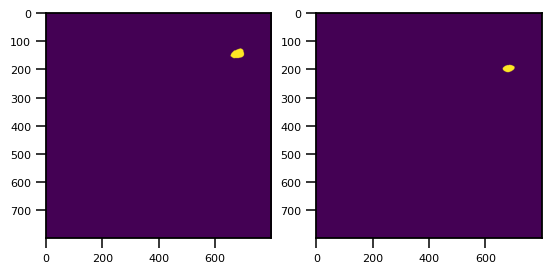

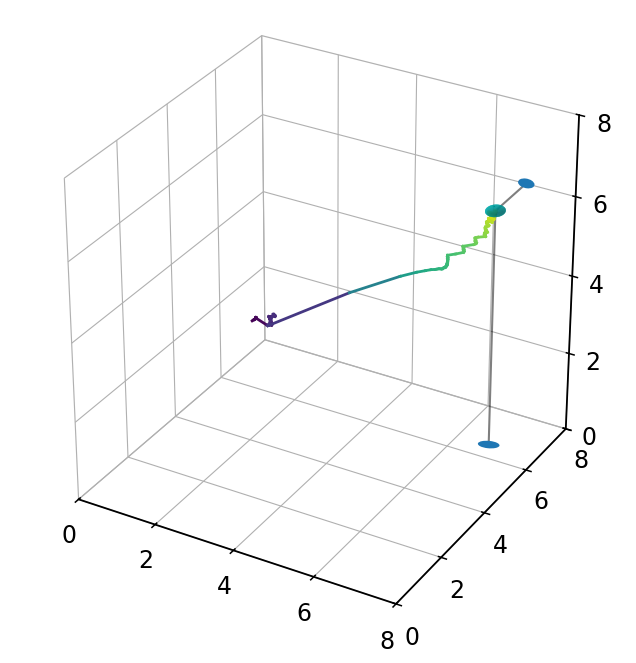

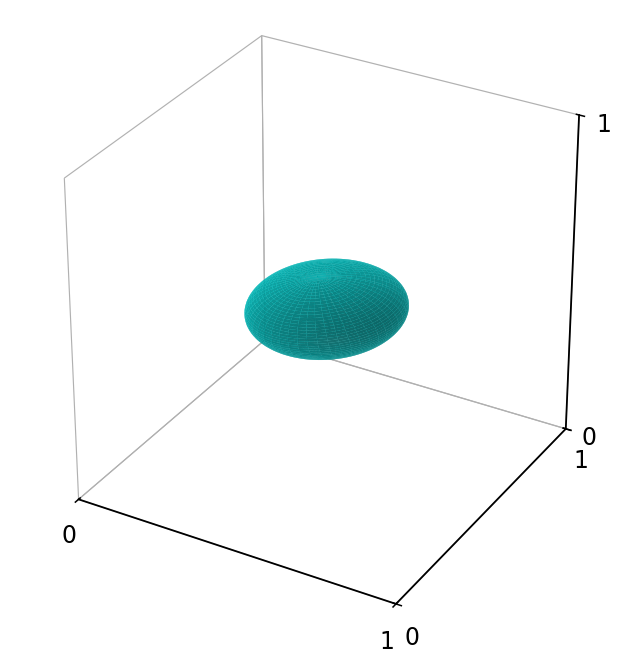

In [ ]:
# For a given frame (mask_number), we visualize what it looks like in top and sideview, as well as in 3D
mask_number = 299
top_mask = top_masks[mask_number].astype(np.uint8)[50:850,100:900]
side_mask = side_masks[mask_number].astype(np.uint8)[50:850,100:900]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(top_mask)
ax2.imshow(side_mask)

side_ellipse, side_visual, cts = getEllipse(side_mask)
top_ellipse, top_visual, cts1 = getEllipse(top_mask)
ellipse_top = {'a': top_ellipse[1][0], 'b': top_ellipse[1][1], 'theta': np.radians(top_ellipse[2])}
ellipse_side = {'a': side_ellipse[1][0], 'b': side_ellipse[1][1], 'theta': np.radians(side_ellipse[2])}

a, b, c, R, phi, theta, psi, Q = ellipsoid_from_projections(ellipse_top, ellipse_side)
plot_ellipsoid(a/2, b/2, c/2, R, (x, y, z), side_visual.shape[0], top_m=top_ellipse, side_m=side_ellipse, mask_number = mask_number)
plot_ellipsoid_zoomed(a/2, b/2, c/2, R, mask_number=mask_number)

In [ ]:
# Calculating volumes, 2D projected areas, and z heights
volumes = []
areas_top = []
areas_side = []
z = []
x = []
y = []
for i in tqdm(range(0, len(top_masks))):
    top_mask = top_masks[i].astype(np.uint8)
    side_mask = side_masks[i].astype(np.uint8)

    side_ellipse, side_visual, cts = getEllipse(side_mask)
    top_ellipse, top_visual, cts1 = getEllipse(top_mask)
    ellipse_top = {'a': top_ellipse[1][0], 'b': top_ellipse[1][1], 'theta': np.radians(top_ellipse[2])}
    ellipse_side = {'a': side_ellipse[1][0], 'b': side_ellipse[1][1], 'theta': np.radians(side_ellipse[2])}

    a, b, c, R, phi, theta, psi, Q = ellipsoid_from_projections(ellipse_top, ellipse_side)
    plot_ellipsoid(a/2, b/2, c/2, R, (x, y, z), side_visual.shape[0], top_m=top_ellipse, side_m=side_ellipse, mask_number = i)
    volumes.append(ellipsoid_volume(a,b,c))
    areas_top.append(ellipse_area(ellipse_top['a'], ellipse_top['b']))
    areas_side.append(ellipse_area(ellipse_side['a'], ellipse_side['b']))
    z.append(side_ellipse[0][1])
    x.append(top_ellipse[0][0])
    y.append(top_ellipse[0][1])

In [ ]:
# Saving datas to csv for later processing
data_to_log = [(side_name, np.mean(np.array(z)), np.mean(np.array(volumes)), np.mean(np.array(areas_top)), np.mean(np.array(areas_side)))]
headers = ['Well', 'Height', 'Volume', 'Top', 'Side']
write_to_csv('swimbladder_data.csv', data_to_log, headers)